In [9]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
    
    size_paths = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith('report')]
        
    for size_path in size_paths:
        size = int(size_path.split('/')[-1])
        with open(os.path.join(size_path, 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
                            
            report[function_name][size] = data['median']['point_estimate']
        

In [10]:
df = pd.DataFrame(report)
df

,cost_le,cost_leq,cost_mod,cost_geq,cost_or,cost_ge,cost_and,cost_add,cost_sub
2,4428970.1,4.564776e+06,4.589344e+06,4.652457e+06,4.573735e+06,4.519627e+06,3.739941e+06,3.802419e+06,3.954402e+06
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.203943e+07,3.300644e+07
256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.232141e+08,4.343062e+08
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.463761e+07,1.605292e+07
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.232822e+06,3.185933e+06
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.072024e+07,9.011001e+06
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.561460e+08,1.542957e+08
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.797441e+07,7.266645e+07


In [11]:
def estimate_params(df, name, transform = lambda x: x):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))].reshape(-1, 1)
    Y = Y[np.logical_not(np.isnan(Y))]
    Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    
    b = linear_regressor.intercept_
    if b < 0:
        b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b):
    Y = df[name].values.reshape(-1, 1)
    X = df.index.values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))]
    Y = Y[np.logical_not(np.isnan(Y))]
    
    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output):
    a, b = estimate_params(df, fun_name)
    output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    plot(df, fun_name, a, b)

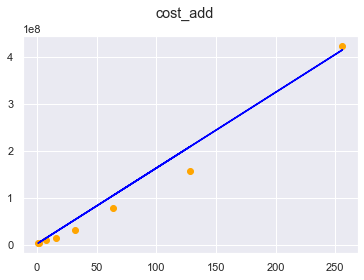

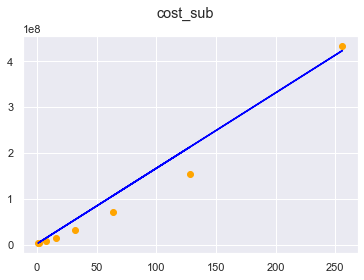

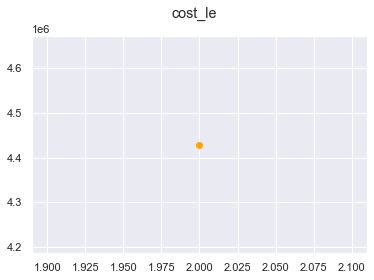

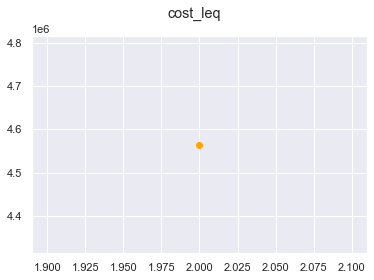

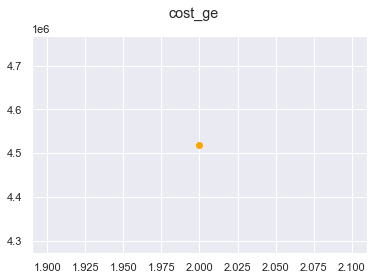

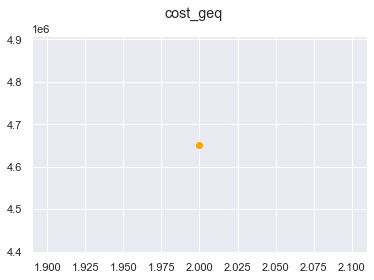

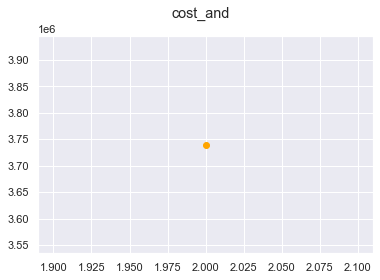

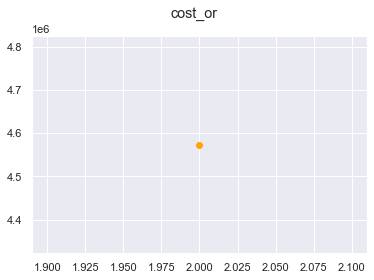

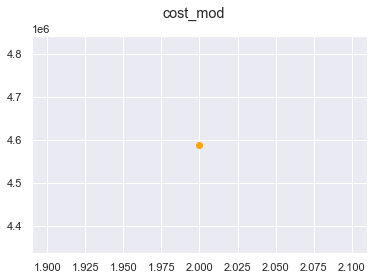

,a,b
cost_add,1610134.1041976009,2192284.895802399
cost_sub,1646426.3066277874,2307975.8856799044
cost_le,0.0,4.42897e+06
cost_leq,0.0,4.56478e+06
cost_ge,0.0,4.51963e+06
cost_geq,0.0,4.65246e+06
cost_and,0.0,3.73994e+06
cost_or,0.0,4.57373e+06
cost_mod,0.0,4.58934e+06


In [12]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)
estimate_plot(df, 'cost_le', output)
estimate_plot(df, 'cost_leq', output)
estimate_plot(df, 'cost_ge', output)
estimate_plot(df, 'cost_geq', output)
estimate_plot(df, 'cost_and', output)
estimate_plot(df, 'cost_or', output)
estimate_plot(df, 'cost_mod', output)

output

In [5]:
output.to_csv("cost_constants.csv")